In [50]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import  Sequential, Model
import matplotlib.pyplot as plt
import os
from tensorflow.python.keras.callbacks import TensorBoard
import numpy as np
from classification_models.tfkeras import Classifiers

In [51]:
directory_train ="divided_data/train"
directory_val ="divided_data/val"
directory_test ="divided_data/test"

In [52]:
batch_size = 16

train_datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,)
    #fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory_train,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    #seed=42
    )


validation_generator = test_datagen.flow_from_directory(
    directory_val,
    target_size=(224,224),
    batch_size=batch_size,
    #class_mode='categorical',
    #shuffle = False
    )

test_generator = test_datagen.flow_from_directory(
    directory_test,
    target_size=(224,224),
    batch_size=32,
    #class_mode='categorical',
    #shuffle=False
    )

Found 130 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


['Chilli', 'Kobe']
2
[[[[0.2627451  0.20392159 0.07450981]
   [0.19607845 0.14509805 0.01176471]
   [0.2627451  0.21176472 0.07843138]
   ...
   [0.86274517 0.70980394 0.07058824]
   [0.90196085 0.7490196  0.10980393]
   [0.8705883  0.7176471  0.07058824]]

  [[0.30980393 0.25490198 0.10980393]
   [0.25882354 0.20784315 0.07058824]
   [0.24313727 0.19215688 0.05490196]
   ...
   [0.8705883  0.7176471  0.07058824]
   [0.89019614 0.7372549  0.09019608]
   [0.8862746  0.73333335 0.08235294]]

  [[0.33333334 0.28235295 0.11764707]
   [0.20784315 0.15294118 0.01568628]
   [0.27058825 0.21568629 0.07843138]
   ...
   [0.87843144 0.7254902  0.07843138]
   [0.8941177  0.7411765  0.09411766]
   [0.8862746  0.73333335 0.08235294]]

  ...

  [[0.70980394 0.6666667  0.5882353 ]
   [0.67058825 0.627451   0.54901963]
   [0.70980394 0.6666667  0.5803922 ]
   ...
   [0.90196085 0.9176471  0.91372555]
   [0.9058824  0.9215687  0.9176471 ]
   [0.8980393  0.91372555 0.909804  ]]

  [[0.7058824  0.654902 

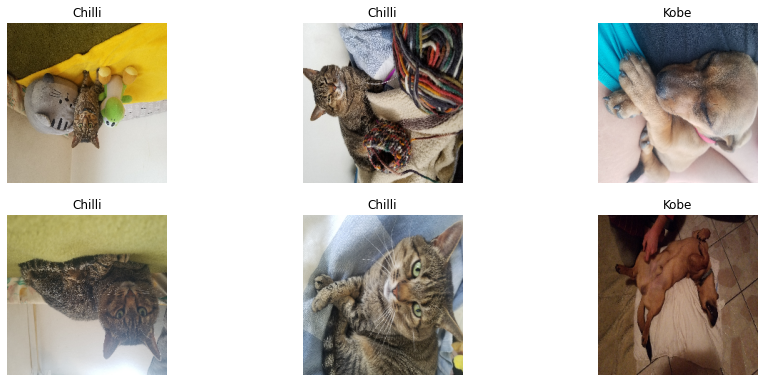

In [53]:
target_labels = next(os.walk(directory_train))[1]
target_labels.sort()
print(target_labels)

num_classes=len(target_labels)
print(num_classes)

batch= next(train_generator)  #vraca sliku i label 
batch_images = np.array(batch[0])
print(batch_images)
batch_labels = np.array(batch[1])
print(batch_labels)



target_labels=np.asarray(target_labels)

plt.subplots(figsize=(15, 10))
for n, i in enumerate(range(6)):
    ax=plt.subplot(3,3,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.argmax(batch_labels[i])])
    plt.axis("off")
plt.show()

In [54]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
model = ResNet18((224,224, 3), weights='imagenet')


print("ResNet18. ", ResNet18)
print("preprocess_input: ", preprocess_input)

base_model = model

base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='sigmoid')(x)
model = Model(inputs=[base_model.input], outputs=[output])
model.summary()




# taken_model = tf.keras.applications.ResNet50V2(weights="imagenet")
# #print(taken_model)

# taken_model_input = taken_model.input
# #print(taken_model_input)

# taken_model_output = taken_model.layers[-2].output
# #print(taken_model_output)


# model = tf.keras.Model(inputs=taken_model_input, outputs=taken_model_output)
# #print(model.summary())

# def add_your_own_head(your_own_model):
#     model= Sequential([
#         your_own_model,
#         Dense(32,activation="relu"),
#         Dropout(0.5),
#         Dense(1, activation="sigmoid")
#     ])
#     model.call = tf.function(model.call)

#     return model

# imported_model = add_your_own_head(model)
# #imported_model.summary()

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


filepath = "best_model_5.pb"

my_callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=14,
                                  min_delta=0.001,),
    keras.callbacks.ModelCheckpoint(filepath,
                                    save_best_only=True,
                                    monitor="val_accuracy",
                                    mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                      factor=0.5,
                                      patience=14,
                                      cooldown=5)
]

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    callbacks = my_callbacks,
    epochs=10)

ResNet18.  <function ResNet18 at 0x0000023EE9921AF8>
preprocess_input:  <function preprocess_input at 0x0000023EE9921A68>
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_198 (ZeroPaddin  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 g2D)                                                               

Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000023EBFDE7A68>
Traceback (most recent call last):
  File "C:\Users\Valentina\anaconda3\envs\keras-env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: deleter


INFO:tensorflow:Assets written to: best_model_5.pb\assets
8/8 [==============================] - 67s 8s/step - loss: 0.6881 - accuracy: 0.7632 - val_loss: 8.7352 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - 30s 4s/step - loss: 1.2746 - accuracy: 0.7982 - val_loss: 0.6638 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - 38s 5s/step - loss: 0.2837 - accuracy: 0.9035 - val_loss: 6.3274 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 4/10
8/8 [==============================] - 35s 4s/step - loss: 0.2457 - accuracy: 0.9211 - val_loss: 24.4950 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 5/10
8/8 [==============================] - 42s 5s/step - loss: 0.4450 - accuracy: 0.8984 - val_loss: 98.9731 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 6/10
8/8 [==============================] - 38s 5s/step - loss: 0.2312 - accuracy: 0.9211 - val_loss: 0.9049 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 7/10
8/8 [=============================

In [55]:
score = model.evaluate(test_generator, batch_size=1, steps=test_generator.samples)
print("Test loss:", score[0])
print("Test accuracy:", score[1]*100)

55/55 [==============================] - 8s 54ms/step - loss: 2.7307 - accuracy: 0.3636
Test loss: 2.7306666374206543
Test accuracy: 36.36363744735718


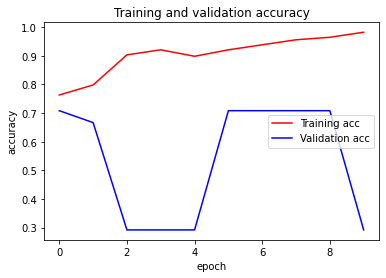

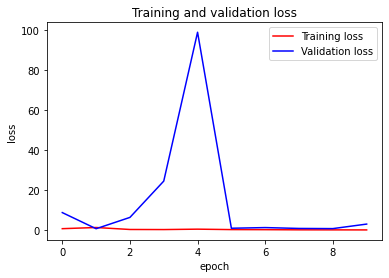

In [56]:
acc =history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss= history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(len(acc))

plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")

plt.ylabel("accuracy")
plt.xlabel("epoch")

plt.legend()
plt.figure()

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.ylabel("loss")
plt.xlabel("epoch")

plt.legend()
plt.show()


# plt.figure(figsize=(15,5))
# plt.subplot(121)
# plt.plot(imported_model.history.history['acc'])
# plt.plot(imported_model.history.history['val_acc'])
# plt.title('Accuracy vs. epochs')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'], loc='lower right')

# plt.subplot(122)
# plt.plot(imported_model.history.history['loss'])
# plt.plot(imported_model.history.history['val_loss'])
# plt.title('Loss vs. epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Training', 'Validation'], loc='upper right')
# plt.show()

ValueError: num must be 1 <= num <= 9, not 10

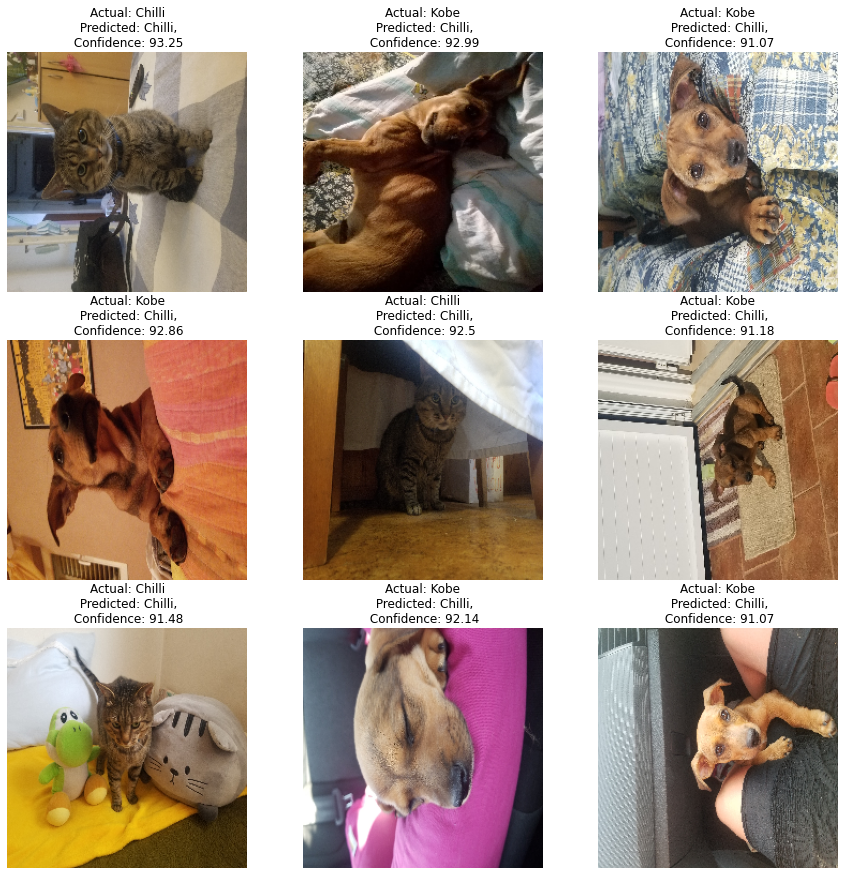

In [57]:
test_generator.reset()
predictions = model.predict(x=test_generator, verbose = 0)
test_generator.reset()

batch = next(test_generator)

batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
#print(batch_labels)

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,15))
for n, i in enumerate(np.arange(9)):
    actual = target_labels[np.argmax(batch_labels[i])]
    predicted = target_labels[np.argmax(predictions[i])]
    confidence = round(100*(np.max(predictions[i])), 2)

    ax = plt.subplot(3,3,n+1)
    plt.imshow(batch_images[i])
    plt.title(f"Actual: {actual}\n Predicted: {predicted},\n Confidence: {confidence}") 
    plt.axis('off')




In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

test_generator.reset()
predictions = model.predict(x=test_generator, verbose = 0)

for i in predictions:
    print(i)

y_predictions = np.argmax(predictions,axis=-1) #ako zelis vidjeti samo most probable prediction za svaki primjer slike unutar test seta, uzima index s najvecnom probabilitijem

test_generator.classes
test_generator.class_indices

y_true_lista= []
for i, img in enumerate(batch_labels):
    y_true=np.argmax(batch_labels[i].reshape(-1))
    for i in y_true:
        y_true_lista.append(i)

cm = confusion_matrix(y_true=y_true_lista, y_pred=y_predictions)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
                          plt.imshow(cm, interpolation="nearest", cmap=cmap)

#plt.imshow(cm, interpolation="nearest", cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(2))
plt.xticks(tick_marks, 2, rotation=45)
plt.yticks(tick_marks, 2)

if normalize:
    cm=cm.astype("float") /cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")

else:
    print("Confusion matrix, without normalization")

print(cm)

thres = cm.max() /2
for i, j in itertools.product(range(cm.shape), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i,j] > thres else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")


    

# cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, acis=-1))
# test_generator.class_indices

# cm_plot_labels =["Chilli", "Kobe"]



